# Blog Post 3: Model Pipeline, Individual Nuclei Segmentation, and Future Work

In this post, we'll go over the following key points:

1. comment on why we're not doing modality separation
1. overview of our current pipeline
    1. discuss our hand designed features
    1. discuss our model choices
    1. discuss our post processing and individual nucleus segmentation
1. discuss our plan moving forward

## about those modalities

In our last post, we did intensive EDA on the different modalities in our training set.  While it ended up being very valuable work for understanding our data, we decided to abandon the separation of modalities here on out.

See [this discussion post](https://www.kaggle.com/c/data-science-bowl-2018/discussion/47640) for some example images of the different training modalities.  In the same post, other Kagglers found that there are **different** modalities in the test set!  And the data curators revealed that there will be even more **different** modalities in the Stage 2 test set!!  As a result, we felt that any model depending on modality metadata would be insufficient for this task, so we are now focusing our efforts on a model that generalizes well for all modalities.

One detail that we have to be careful of, however, is that some modalities have dark nuclei on white backgrounds, while some have bright nuclei on dark backgrounds.  In order to present our model with appropriate training data, we invert images found on white backgrounds.  Currently, we simply take the mean of an image, and if it's greater than a constant threshold, we invert.

## current pipeline

The pipeline has a few steps:

* read in data
* preprocess and resize to the same shape (we're using (256 x 256))
* expand each pixel's features from RGB to a set of hand-designed features
* train a Regressor with Mini Batch SGD on pixel data (flatten all images to make a large corpus on pixels)
* predict the regression output on each pixel in an image, to form a prediction for such an image
* perform a local thresholding using a combination of otsu's binarization and non maximum supression
* perform individual nucleus segmentation
* submit and get $$$

### reading data and preprocessing

In [7]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.dpi"] = 50

import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from deton8.utils import DataReader
from sklearn.model_selection import train_test_split

training = DataReader("../data/training/")
train_metadata, x_train = training.get()

y_train = np.stack(training.masks)
train_metadata, val_metadata, x_train, x_val, y_train, y_val = train_test_split(train_metadata, x_train, y_train, train_size = 0.8)

/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### basis transformation

The first step in our pipeline relies on transforming the pixels from our original RGB feature space to an expanded space of 9 hand-designed features.  In the following cells, we'll present some examples of our chosen features.  Here's a listing:

1. Red Channel
2. Green Channel
3. Blue Channel
4. pixel's z-score w.r.t image
5. bilateral filter
6. average of RGB Channels after a rescaling between 2% and 98% of the full range
7. average of RGB Channels after a Contrast Limited Adaptive Histogram Equalization
8. average of RGB Channels after a dilation
9. pixel's mean distance from it's 8-connectivity neighbors using the previous 8 features as dimensions

In [ ]:
from deton8.computer_vision import ColorMatcher
cm = ColorMatcher()
x_train_preprocessed = cm.fit_transform(np.expand_dims(x_train[9], axis = 0), x_train)

In [ ]:
x_val_preprocessed = cm.fit_transform(np.expand_dims(x_train[9], axis = 0), x_val)

In [ ]:
from deton8.analytical import BasisTransformer
transformer = BasisTransformer()
x_train_transformed = transformer.fit_transform(np.array(x_train_preprocessed))

In [ ]:
x_val_transformed = transformer.fit_transform(np.array(x_val_preprocessed))

In [ ]:
img = x_val_transformed[100]

#### z-score

We first take the average of the image channels and then compute a pixel's deviation from the overall mean divided by the overall standard deviation.  Observe some images below.

In [ ]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 3])
plt.title("z-score")

We chose to include this feature as it provides a clear contrast between light pixels which represent nuclei and the background of the image.

#### bilateral filter

A bilateral filter is an edge preserving filter that reduces noise in an image.  We chose to include this filter because it will preserve the edges of our nuclei while smoothing brightness into somewhat darker areas of the nuclei.

In [ ]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 4])
plt.title("bilateral filter")

#### rescaling

This feature takes the 2nd and 98th percentile of an image and rescales the values to be in this range.  The effect is an increase of 
contrast, since all values from the 98th to the 100th percentile are set to the maximum value and all values from the 0th to the 2nd percentile are set to the minimum value.  It also stretches the values inside the 2nd to 98th percentile a bit.  As we can see, the effect is quite desirable.  Our true nuclei are amplified, and noise around the nuclei isn't too drastically.

In [ ]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 5])
plt.title("rescaling")

#### CL AHE

This feature performs a Contrast Limited Adaptive Histogram Equalization, which is quite a mouthful.  Conceptually we can think of this method as performing a sort of local rescaling -- which is quite attractive to us.  We increase the contrast in a local region rather than a global region, which will exclude that large portion of background "zeros".  The "Contrast Limited" portion takes the adaptive (local) histogram and will "clip" bins at a certain threshold, redistributing weight to the other bins equally.  Refer to [this wikipedia article](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) for more details.

In [ ]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 6])
plt.title("cl ahe")

#### dilation

This features dialates bright areas in an image.  Here we use a structuring element of a large matrix of ones, but we may experiment with a disk element to dilate more naturally for nuclei.  It seems that we have somewhat of a strange effect on the image below.  However, we like this feature since it provides a region around the nuclei which decays in magnitude as it gets further from the center of a nucleus.

In [ ]:
plt.subplot(121)
plt.imshow(img[:, :, 0])
plt.title("original")
plt.subplot(122)
plt.imshow(img[:, :, 7])
plt.title("dilation results")

### Training

We have 670 images in our training set and we resize each image to be 256 x 256.  Since we're simply training our models with our basis transformed pixels, we have 670 * 256 * 256 points at this point in our training task.  Since this is over 43 million data points, we're not going to be able to train this dataset at once, so we'll have to rely on online, or mini-batch learning.  

So, we've restricted ourselves to two regressors from `scikit-learn`, the `SGDRegressor` using an elastic net penalty, and the `PassiveAggressiveRegressor`.  Both regressors support mini-batch learning.

We chose to frame this problem as a regression problem so we predict "probabilities" and then perform the local thresholding to determine how to binarize ourselves.

In [9]:
from deton8.utils import flatten_data

y_dev = y_train

x_dev_flat, y_dev_flat = flatten_data(x_train_transformed, y_dev, skip=1)
x_val_flat, y_val_flat = flatten_data(x_val_transformed, y_val, skip=1)

NameError: name 'x_train_transformed' is not defined

In [ ]:
from deton8.models import MiniBatchRegressor
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor
from tqdm import tqdm_notebook as tqdm

sgd_regressor = MiniBatchRegressor(
    regressor=SGDRegressor(penalty='elasticnet', l1_ratio=0.11),
    batch_size=1000,
    num_iters=50000,
    tqdm=tqdm
)

sgd_regressor.fit(x_dev_flat, y_dev_flat)

In [ ]:
from sklearn.linear_model import PassiveAggressiveRegressor

pa_regressor = MiniBatchRegressor(
    regressor=PassiveAggressiveRegressor(C = .2),
    batch_size=1000,
    num_iters=1000,
    tqdm=tqdm
)

pa_regressor.fit(x_dev_flat, y_dev_flat)

In [ ]:
from deton8.visualization import plot_prediction

In [ ]:
num = 100
plot_prediction(sgd_regressor, x_val_transformed[num], y_val[num])
plot_prediction(pa_regressor, x_val_transformed[num], y_val[num])

In [ ]:
num = 2
plot_prediction(sgd_regressor, x_val_transformed[num], y_val[num])
plot_prediction(pa_regressor, x_val_transformed[num], y_val[num])

In [ ]:
num = 5
plot_prediction(sgd_regressor, x_val_transformed[num], y_val[num])
plot_prediction(pa_regressor, x_val_transformed[num], y_val[num])

# UNet
By qualitative inspection, we recognized that the `Passive Aggressive Regressor` and `SGD Regressor` both did well on most datasets, with each model performing better than the other on certain images. Thus, we decided to create a `UNet` with these regressors' outputs as the pixel features. Below we stack these regressors' outputs as features and preprocess the data:

In [ ]:
x_dev_extended = np.zeros((len(x_dev), 256, 256, 2))
x_dev_extended[:, :, :, 0] = sgd_regressor.predict_images(x_train_transformed)
x_dev_extended[:, :, :, 1] = pa_regressor.predict_images(x_train_transformed)

In [ ]:
x_val_extended = np.zeros((len(x_val), 256, 256, 2))
x_val_extended[:, :, :, 0] = sgd_regressor.predict_images(x_val_transformed)
x_val_extended[:, :, :, 1] = pa_regressor.predict_images(x_val_transformed)

In [99]:
from deton8.preprocess import preprocess
x_train_extended = preprocess(x_train)
x_val_extended = preprocess(x_val)

100%|██████████| 134/134 [00:06<00:00, 21.80pair/s]


In [178]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

We also decided to use a generator to reduce overfitting. We used Keras' standard ImageDataGenerator to do so:

In [101]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            shear_range=0.2).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            horizontal_flip=True, 
            vertical_flip=True,
            zoom_range=0.2,
            shear_range=0.2).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

For metrics, we decided to use pixel-wise dice coefficient and F1. We also describe the architecture of the UNet Below

In [180]:
def dice_coef(y_true, y_pred):
    smooth = .1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

input_layer = Input(shape=x_train_extended.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model_regress = Model(input_layer, output_layer)

For the UNet, we decided to use the negative dice coefficient as loss with RMSProp for optimization

In [184]:
import tensorflow as tf
def dice_coef_loss(y_true, y_pred):
    return -1*dice_coef(y_true, y_pred)

model_regress.compile(optimizer=RMSprop(0.0002), loss=dice_coef_loss, metrics=[dice_coef, f1])

In [187]:
model_regress.save_weights("../weights/unet_weights.h5")

In [186]:
hist = model_regress.fit_generator(my_generator(x_train_extended, np.expand_dims(y_train, axis = 3), 8),
                           steps_per_epoch = 25,
                           validation_data = (x_val_extended, np.expand_dims(y_val, axis = 3)),
                           epochs=500, verbose=True)

Epoch 1/500


/Users/williamlevine/anaconda2/envs/py36/lib/python3.6/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (536, 256, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


25/25 [==============================] - 71s 3s/step - loss: -0.8676 - dice_coef: 0.8676 - f1: 0.8749 - val_loss: -0.8897 - val_dice_coef: 0.8897 - val_f1: 0.8917
Epoch 2/500
25/25 [==============================] - 83s 3s/step - loss: -0.8693 - dice_coef: 0.8693 - f1: 0.8779 - val_loss: -0.8898 - val_dice_coef: 0.8898 - val_f1: 0.8917
Epoch 3/500
25/25 [==============================] - 61s 2s/step - loss: -0.8733 - dice_coef: 0.8733 - f1: 0.8809 - val_loss: -0.8901 - val_dice_coef: 0.8901 - val_f1: 0.8921
Epoch 4/500
25/25 [==============================] - 58s 2s/step - loss: -0.8650 - dice_coef: 0.8650 - f1: 0.8731 - val_loss: -0.8900 - val_dice_coef: 0.8900 - val_f1: 0.8920
Epoch 5/500
25/25 [==============================] - 60s 2s/step - loss: -0.8675 - dice_coef: 0.8675 - f1: 0.8760 - val_loss: -0.8900 - val_dice_coef: 0.8900 - val_f1: 0.8920
Epoch 6/500
25/25 [==============================] - 57s 2s/step - loss: -0.8515 - dice_coef: 0.8515 - f1: 0.8591 - val_loss: -0.8903 - v

KeyboardInterrupt: 

In [11]:
from deton8.pipeline import pipeline
from deton8.components import watershed_cc
x_train_output, test_metadata = pipeline('../data/training/')

100%|██████████| 670/670 [00:32<00:00, 20.77pair/s]


For segmentation, we decided to use a modified version of Watershed. We found that raw watershed produces too many local maxes, so we decided to iterate accross clusters of local maxes and select the maximum of the maxima. Thus, we split clusters as infrequently as possible. Below are the results of our entire semgentation pipeline.

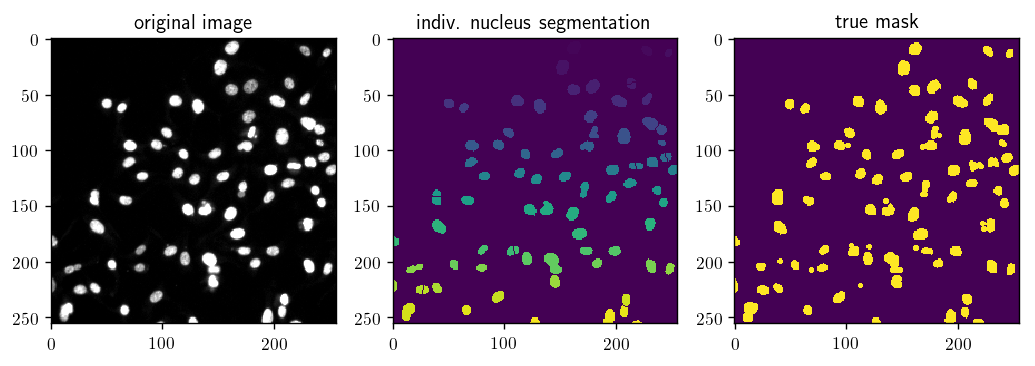

In [583]:
num = 0
plot_segmentation(x_val_transformed[num], postprocess(model_regress.predict(np.expand_dims(x_val_extended[num], axis=0)), min_area=10) > 0, y_val[num])